### Comparing Custom SHAP Approximator with Original SHAP on Simulated Data

In this notebook, we will:

- Simulate both tabular and sequential data with known true feature importances.
- Train models (XGBoost for tabular data and LSTM for sequential data) on the simulated data.
- Compute SHAP values using both the original SHAP package and a custom SHAP approximator.
- Compare the SHAP values from both methods with each other and with the true feature importances.
- Analyze and visualize the results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr

from src.simulation import TabularDataSimulator, SequentialDataSimulator
from src.shap_engine import TabularSHAPApproximator, SequentialSHAPApproximator

/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Simulate Tabular Data


In [2]:
# Simulate tabular data
tabular_simulator = TabularDataSimulator(n_samples=1000, n_features=10)
X, y = tabular_simulator.get_data()
true_importances = tabular_simulator.get_true_importances()

# Convert to NumPy array if necessary
if isinstance(X, pd.DataFrame):
    X = X.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
# Train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [4]:
# Compute SHAP values using SHAP package
explainer_shap = shap.TreeExplainer(model_xgb)
shap_values_shap = explainer_shap.shap_values(X_test)

In [5]:
# Initialize custom SHAP approximator
custom_shap_approximator = TabularSHAPApproximator(model_xgb, X_train, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom = custom_shap_approximator.compute_shap_values(X_test)


In [6]:
# Compute mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values_shap), axis=0)
mean_abs_custom_shap_values = np.mean(np.abs(shap_values_custom), axis=0)

# Normalize SHAP values
norm_mean_abs_shap_values = mean_abs_shap_values / np.sum(mean_abs_shap_values)
norm_mean_abs_custom_shap_values = mean_abs_custom_shap_values / np.sum(mean_abs_custom_shap_values)

# Create DataFrame for comparison
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'True Importance': true_importances,
    'Original SHAP': norm_mean_abs_shap_values,
    'Custom SHAP': norm_mean_abs_custom_shap_values
})

print(comparison_df)

     Feature  True Importance  Original SHAP  Custom SHAP
0  Feature 0         0.037092       0.025948     0.027405
1  Feature 1         0.097485       0.102313     0.103664
2  Feature 2         0.106217       0.112381     0.110424
3  Feature 3         0.122961       0.096582     0.095951
4  Feature 4         0.126375       0.122825     0.121165
5  Feature 5         0.094214       0.088919     0.089026
6  Feature 6         0.001638       0.005189     0.008178
7  Feature 7         0.009646       0.006937     0.010858
8  Feature 8         0.056385       0.050629     0.051608
9  Feature 9         0.347986       0.388279     0.381721


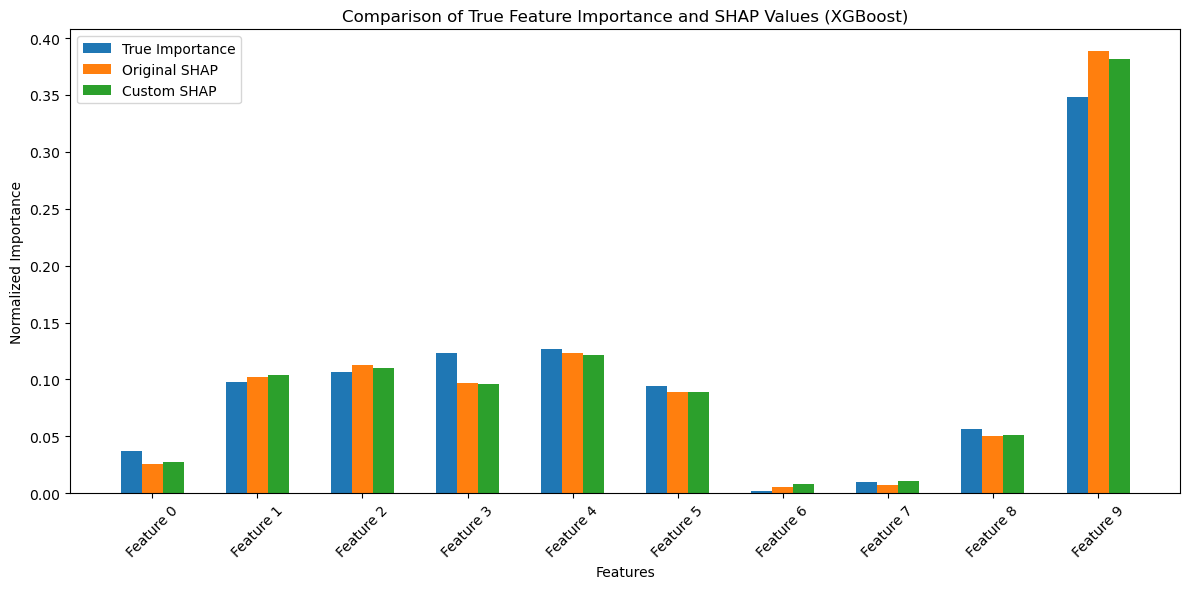

In [7]:
# Plot comparison
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(feature_names))

plt.bar(index, comparison_df['True Importance'], bar_width, label='True Importance')
plt.bar(index + bar_width, comparison_df['Original SHAP'], bar_width, label='Original SHAP')
plt.bar(index + 2*bar_width, comparison_df['Custom SHAP'], bar_width, label='Custom SHAP')

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Feature Importance and SHAP Values (XGBoost)')
plt.xticks(index + bar_width, feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# Correlation with true importances
corr_true_original, _ = pearsonr(true_importances, norm_mean_abs_shap_values)
corr_true_custom, _ = pearsonr(true_importances, norm_mean_abs_custom_shap_values)

print(f'Correlation between True Importances and Original SHAP (XGBoost): {corr_true_original:.4f}')
print(f'Correlation between True Importances and Custom SHAP (XGBoost): {corr_true_custom:.4f}')

Correlation between True Importances and Original SHAP (XGBoost): 0.9936
Correlation between True Importances and Custom SHAP (XGBoost): 0.9930


#### Simulate Sequential Data

In [9]:
# Simulate sequential data
sequential_simulator = SequentialDataSimulator(n_samples=1000, timesteps=10, features=1)
X_seq, y_seq = sequential_simulator.get_data()
true_influences = sequential_simulator.get_true_importances()

# Ensure correct shape
if len(X_seq.shape) != 3:
    X_seq = X_seq.reshape((X_seq.shape[0], sequential_simulator.timesteps, sequential_simulator.features))

# Split data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2)

In [10]:
# Define LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Set parameters
input_size = sequential_simulator.features
hidden_size = 50
output_size = 1

# Initialize model, loss function, and optimizer
model_lstm = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)

# Train LSTM model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model_lstm.train()
    permutation = torch.randperm(X_train_seq_tensor.size(0))
    for i in range(0, X_train_seq_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_seq_tensor[indices], y_train_seq_tensor[indices]

        # Forward pass
        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 7.6565
Epoch [2/10], Loss: 7.8105
Epoch [3/10], Loss: 8.9329
Epoch [4/10], Loss: 11.3196
Epoch [5/10], Loss: 6.8594
Epoch [6/10], Loss: 7.1976
Epoch [7/10], Loss: 7.2751
Epoch [8/10], Loss: 6.5802
Epoch [9/10], Loss: 5.9236
Epoch [10/10], Loss: 6.6933


In [11]:
# Sample data for SHAP computations
X_train_sample_seq = X_train_seq[:100]
X_test_sample_seq = X_test_seq[:10]

# Compute SHAP values using DeepExplainer
model_lstm.eval()
X_train_sample_seq_tensor = torch.tensor(X_train_sample_seq, dtype=torch.float32)
explainer_shap_seq = shap.DeepExplainer(model_lstm, X_train_sample_seq_tensor)
shap_values_shap_seq = explainer_shap_seq.shap_values(torch.tensor(X_test_sample_seq, dtype=torch.float32), check_additivity=False)

/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [12]:
# Initialize custom SHAP approximator
custom_shap_approximator_seq = SequentialSHAPApproximator(model_lstm, X_train_sample_seq, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom_seq = custom_shap_approximator_seq.compute_shap_values(X_test_sample_seq)

# Compute SHAP values using custom approximator in batch mode
shap_values_custom_seq_batch = custom_shap_approximator_seq.batch_approximate_shap_values(X_test_sample_seq)

In [13]:
# Compute mean absolute SHAP values for the original SHAP values
mean_abs_shap_values_seq = np.mean(np.abs(shap_values_shap_seq), axis=0).flatten()
# Compute mean absolute SHAP values for the custom SHAP values (per sample and batch mode)
mean_abs_custom_shap_values_seq = np.mean(np.abs(shap_values_custom_seq), axis=0).flatten()
mean_abs_custom_shap_values_seq_batch = np.mean(np.abs(shap_values_custom_seq_batch), axis=0).flatten()

# Normalize SHAP values
norm_mean_abs_shap_values_seq = mean_abs_shap_values_seq / np.sum(mean_abs_shap_values_seq)
norm_mean_abs_custom_shap_values_seq = mean_abs_custom_shap_values_seq / np.sum(mean_abs_custom_shap_values_seq)
norm_mean_abs_custom_shap_values_seq_batch = mean_abs_custom_shap_values_seq_batch / np.sum(mean_abs_custom_shap_values_seq_batch)

# Create DataFrame for comparison
time_steps = np.arange(len(true_influences))
comparison_seq_df = pd.DataFrame({
    'Time Step': time_steps,
    'True Influence': true_influences,
    'Original SHAP': norm_mean_abs_shap_values_seq,
    'Custom SHAP (Per Sample)': norm_mean_abs_custom_shap_values_seq,
    'Custom SHAP (Batch)': norm_mean_abs_custom_shap_values_seq_batch
})

print(comparison_seq_df)

   Time Step  True Influence  Original SHAP  Custom SHAP (Per Sample)  \
0          0        0.024414       0.031269                  0.030586   
1          1        0.017953       0.016756                  0.030576   
2          2        0.126756       0.126546                  0.137733   
3          3        0.002031       0.102479                  0.093491   
4          4        0.280245       0.096856                  0.102223   
5          5        0.148073       0.072961                  0.063749   
6          6        0.278551       0.165826                  0.159051   
7          7        0.046341       0.301442                  0.295192   
8          8        0.065718       0.084064                  0.079102   
9          9        0.009917       0.001800                  0.008296   

   Custom SHAP (Batch)  
0             0.025900  
1             0.035832  
2             0.130100  
3             0.084025  
4             0.107249  
5             0.095585  
6             0.14609

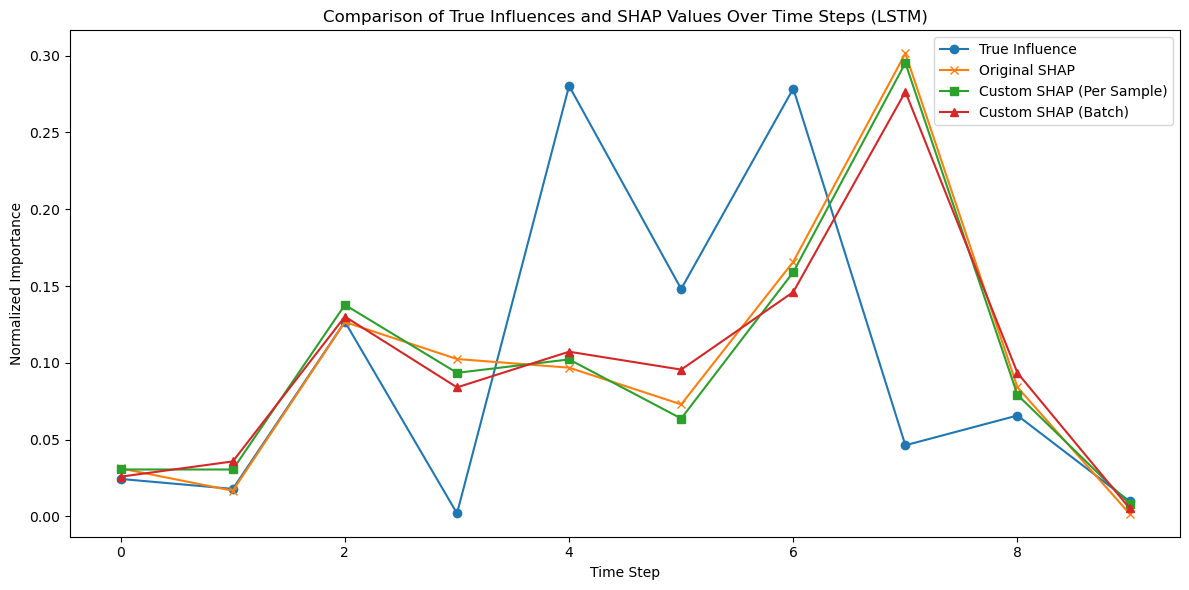

In [14]:
# Plot comparison over time steps
plt.figure(figsize=(12, 6))
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['True Influence'], marker='o', label='True Influence')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Original SHAP'], marker='x', label='Original SHAP')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Custom SHAP (Per Sample)'], marker='s', label='Custom SHAP (Per Sample)')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Custom SHAP (Batch)'], marker='^', label='Custom SHAP (Batch)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Influences and SHAP Values Over Time Steps (LSTM)')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Correlation with true influences
corr_true_original_seq, _ = pearsonr(true_influences, norm_mean_abs_shap_values_seq)
corr_true_custom_seq, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_seq)
corr_true_custom_seq_batch, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_seq_batch)

print(f'Correlation between True Influences and Original SHAP (LSTM): {corr_true_original_seq:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Per Sample, LSTM): {corr_true_custom_seq:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Batch, LSTM): {corr_true_custom_seq_batch:.4f}')

Correlation between True Influences and Original SHAP (LSTM): 0.2523
Correlation between True Influences and Custom SHAP (Per Sample, LSTM): 0.2540
Correlation between True Influences and Custom SHAP (Batch, LSTM): 0.2974


#### Simulate Sequential Data and Train Transformer Model

In [16]:
# Define Transformer model in PyTorch
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        transformer_out = self.transformer(x)
        out = self.fc(transformer_out[:, -1, :])
        return out

# Set parameters
hidden_size = 50
nhead = 5
num_layers = 2

# Initialize model, loss function, and optimizer
model_transformer = TransformerModel(input_size, hidden_size, output_size, nhead, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)

# Train Transformer model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model_transformer.train()
    permutation = torch.randperm(X_train_seq_tensor.size(0))
    for i in range(0, X_train_seq_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_seq_tensor[indices], y_train_seq_tensor[indices]

        # Forward pass
        outputs = model_transformer(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/10], Loss: 13.2178
Epoch [2/10], Loss: 11.3921
Epoch [3/10], Loss: 6.4324
Epoch [4/10], Loss: 4.7378
Epoch [5/10], Loss: 8.6315
Epoch [6/10], Loss: 6.8293
Epoch [7/10], Loss: 7.5125
Epoch [8/10], Loss: 7.6445
Epoch [9/10], Loss: 8.8837
Epoch [10/10], Loss: 8.2581


In [17]:
# Sample data for SHAP computations
X_train_sample_seq = X_train_seq[:100]
X_test_sample_seq = X_test_seq[:10]

# Compute SHAP values using DeepExplainer
model_transformer.eval()
X_train_sample_seq_tensor = torch.tensor(X_train_sample_seq, dtype=torch.float32)
explainer_shap_transformer = shap.DeepExplainer(model_transformer, X_train_sample_seq_tensor)
shap_values_shap_transformer = explainer_shap_transformer.shap_values(torch.tensor(X_test_sample_seq, dtype=torch.float32), check_additivity=False)

# Ensure correct output format
if isinstance(shap_values_shap_transformer, list):
    shap_values_shap_transformer = shap_values_shap_transformer[0]

/home/niyang/miniconda3/envs/shap/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [18]:
# Initialize custom SHAP approximator
custom_shap_approximator_transformer = SequentialSHAPApproximator(model_transformer, X_train_sample_seq, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom_transformer = custom_shap_approximator_transformer.compute_shap_values(X_test_sample_seq)

# Compute SHAP values using custom approximator in batch mode
shap_values_custom_transformer_batch = custom_shap_approximator_transformer.batch_approximate_shap_values(X_test_sample_seq)

In [19]:
# Compute mean absolute SHAP values for the original SHAP values
mean_abs_shap_values_transformer = np.mean(np.abs(shap_values_shap_transformer), axis=0).flatten()
# Compute mean absolute SHAP values for the custom SHAP values (per sample and batch mode)
mean_abs_custom_shap_values_transformer = np.mean(np.abs(shap_values_custom_transformer), axis=0).flatten()
mean_abs_custom_shap_values_transformer_batch = np.mean(np.abs(shap_values_custom_transformer_batch), axis=0).flatten()

# Normalize SHAP values
norm_mean_abs_shap_values_transformer = mean_abs_shap_values_transformer / np.sum(mean_abs_shap_values_transformer)
norm_mean_abs_custom_shap_values_transformer = mean_abs_custom_shap_values_transformer / np.sum(mean_abs_custom_shap_values_transformer)
norm_mean_abs_custom_shap_values_transformer_batch = mean_abs_custom_shap_values_transformer_batch / np.sum(mean_abs_custom_shap_values_transformer_batch)

# Create DataFrame for comparison
time_steps = np.arange(len(true_influences))
comparison_transformer_df = pd.DataFrame({
    'Time Step': time_steps,
    'True Influence': true_influences,
    'Original SHAP': norm_mean_abs_shap_values_transformer,
    'Custom SHAP (Per Sample)': norm_mean_abs_custom_shap_values_transformer,
    'Custom SHAP (Batch)': norm_mean_abs_custom_shap_values_transformer_batch
})

print(comparison_transformer_df)

   Time Step  True Influence  Original SHAP  Custom SHAP (Per Sample)  \
0          0        0.024414       0.087452                  0.028029   
1          1        0.017953       0.081374                  0.057169   
2          2        0.126756       0.174947                  0.040920   
3          3        0.002031       0.088344                  0.034205   
4          4        0.280245       0.042002                  0.076176   
5          5        0.148073       0.063405                  0.033215   
6          6        0.278551       0.056410                  0.082372   
7          7        0.046341       0.087517                  0.255983   
8          8        0.065718       0.075819                  0.034049   
9          9        0.009917       0.242730                  0.357881   

   Custom SHAP (Batch)  
0             0.017495  
1             0.045562  
2             0.058454  
3             0.005488  
4             0.069712  
5             0.040625  
6             0.09385

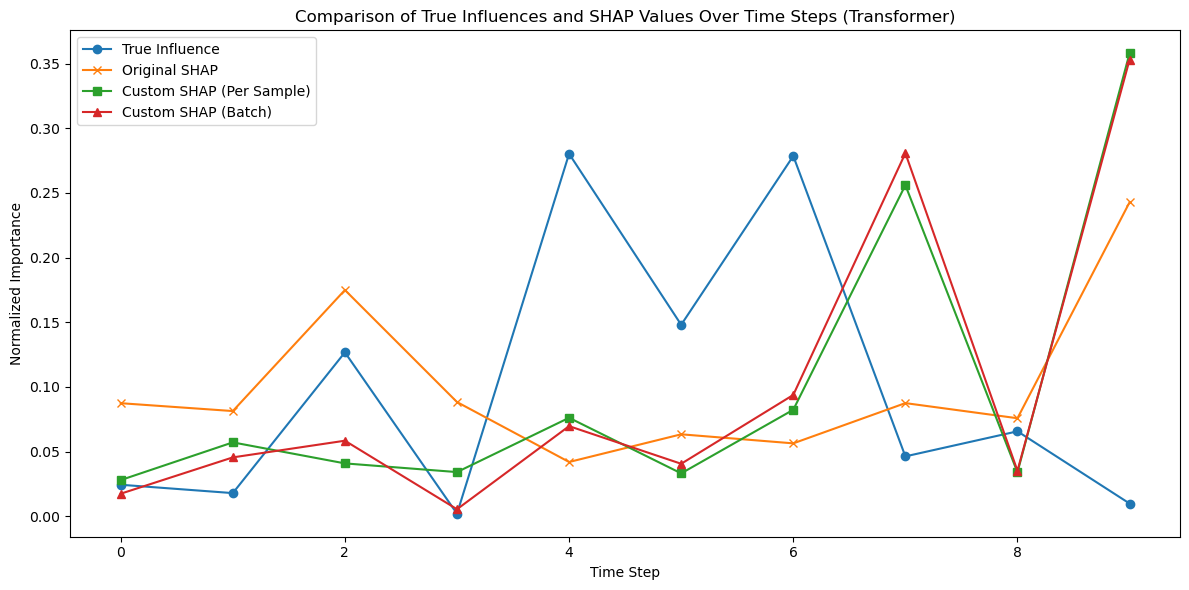

In [20]:
# Plot comparison over time steps
plt.figure(figsize=(12, 6))
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['True Influence'], marker='o', label='True Influence')
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['Original SHAP'], marker='x', label='Original SHAP')
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['Custom SHAP (Per Sample)'], marker='s', label='Custom SHAP (Per Sample)')
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['Custom SHAP (Batch)'], marker='^', label='Custom SHAP (Batch)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Influences and SHAP Values Over Time Steps (Transformer)')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Correlation with true influences
corr_true_original_transformer, _ = pearsonr(true_influences, norm_mean_abs_shap_values_transformer)
corr_true_custom_transformer, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_transformer)
corr_true_custom_transformer_batch, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_transformer_batch)

print(f'Correlation between True Influences and Original SHAP (Transformer): {corr_true_original_transformer:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Per Sample, Transformer): {corr_true_custom_transformer:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Batch, Transformer): {corr_true_custom_transformer_batch:.4f}')

Correlation between True Influences and Original SHAP (Transformer): -0.4380
Correlation between True Influences and Custom SHAP (Per Sample, Transformer): -0.2417
Correlation between True Influences and Custom SHAP (Batch, Transformer): -0.1842
